### Import libraries

In [217]:
import qiskit_nature
from qiskit_algorithms import NumPyMinimumEigensolver, VQE
from qiskit_nature.second_q.formats.molecule_info import MoleculeInfo
from qiskit_nature.second_q.mappers import ParityMapper, JordanWignerMapper
from qiskit_nature.second_q.circuit.library import PUCCD, PUCCSD, UCCSD, SUCCD, HartreeFock
qiskit_nature.settings.use_pauli_sum_op = False
from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit_aer.primitives import Estimator
from qiskit.quantum_info import Statevector
from qiskit.circuit import Parameter, QuantumCircuit, ParameterVector, QuantumRegister
from qiskit.circuit.library import TwoLocal, CZGate, CXGate
from qiskit_algorithms.optimizers import SLSQP, COBYLA
from qiskit_aer.noise import NoiseModel
from qiskit_ibm_runtime import SamplerV2
from qiskit_ibm_runtime.fake_provider import FakeManilaV2
import pyscf
import pyscf.mcscf
import ffsim
import numpy as np
import matplotlib.pyplot as plt

### Define the system's qubit Hamiltonian

In [163]:
def get_qubit_op(dist):
    '''
    Constructs the qubit Hamiltonian operator.
    
    Args:
        int (or range): interatomic distances.
    
    Returns:
        qubit_op (tuple): SparsePauliOp object -- qubit-basis Hamiltonian.
        num_particles (tuple): particle per orbital. 
        num_spatial_orbitals (int): number of spatial orbitals.
        problem: class of Qiskit problems.
        mapper: type of Qiskit fermion-qubit mapping used
    '''

    # Change system here
    molecule = MoleculeInfo(
        symbols=["H", "H"],
        coords=([0.0, 0.0, 0.0], [0.0, 0.0, dist]),
        multiplicity=1, 
        charge=0,
    )
    
    driver = PySCFDriver.from_molecule(molecule)
    problem = driver.run()

    num_particles = problem.num_particles
    num_spatial_orbitals = problem.num_spatial_orbitals
    
    mapper = JordanWignerMapper()
    qubit_op = mapper.map(problem.second_q_ops()[0])

    return qubit_op, num_particles, num_spatial_orbitals, problem, mapper

### Define a custom ansatz not part of an existing Qiskit library 

In [235]:
def create_custom_ansatz(num_qubits, reps=2):
    '''
    Creates a custom ansatz as a parameterized QuantumCircuit.

    Args:
    - num_qubits (int): Number of qubits.
    - reps (int): Number of repetitions for the ansatz layers.

    Returns:
    - ansatz: The constructed ansatz circuit.
    '''
    
    ansatz = QuantumCircuit(num_qubits)
    params = ParameterVector('θ', length=num_qubits * reps * 4)  # Adjust length as needed

    param_idx = 0
    for _ in range(reps):
        for q in range(num_qubits):
            ansatz.ry(params[param_idx], q)
            param_idx += 1

        for q in range(num_qubits - 1):
            ansatz.append(CZGate(), [q, q + 1])

        for q in range(num_qubits):
            ansatz.rx(params[param_idx], q)
            param_idx += 1

        for q in range(num_qubits - 1):
            ansatz.cx(q, q + 1)

    return ansatz

### Perform the VQE calculation 

In [243]:
def VQE_calculation(interatomic_distance, optimizer, device, ansatz):
    '''
    Performs the VQE calculation using a given ansatz and optimizer.

    Args:
    - interatomic_distance (list): A list of interatomic distances for the curve.
    - optimizer (str): A Qiskit-supported optimizer.
    - device (str): A quantum simulator (or device).
    - ansatz (str): The chosen ansatz. Note that if a chosen ansatz is not part of a Qiskit library, it must be input as a string.

    Returns:
    - vqe_energies (list): The resulting VQE energies.
    '''

    vqe_energies = []
    wavefunction = []
    
    for dist in interatomic_distance:
        (qubit_op, num_particles, num_spatial_orbitals, problem, mapper) = get_qubit_op(dist)
        init_state = HartreeFock(num_spatial_orbitals, num_particles, mapper)
        if ansatz == UCCSD or ansatz == PUCCD or ansatz == PUCCSD or ansatz == SUCCD:        
            var_form = ansatz(num_spatial_orbitals, num_particles, mapper, initial_state=init_state) # The UCC family
            vqe = VQE(device, var_form, optimizer, initial_point=[0] * var_form.num_parameters,)
        elif ansatz == "HEA":
            var_form = TwoLocal(rotation_blocks='ry', entanglement_blocks='cz', entanglement='full', reps=2) # The hardware-efficient ansatz
            vqe = VQE(device, var_form, optimizer)
        elif ansatz == "custom":
            var_form = create_custom_ansatz(qubit_op.num_qubits) # A custom ansatz
            vqe = VQE(device, var_form, optimizer)
        vqe_calc = vqe.compute_minimum_eigenvalue(qubit_op)
        vqe_result = problem.interpret(vqe_calc).total_energies[0].real
        vqe_energies.append(vqe_result)
        vqe_circuit = vqe_calc.optimal_circuit
        optimal_params = vqe_calc.optimal_parameters
        optimized_circuit = vqe_circuit.assign_parameters(optimal_params)
        state = Statevector.from_instruction(optimized_circuit.decompose(reps = 5))
        wavefunction.append(state.data)

    return vqe_energies

In [156]:
interatomic_distance = np.arange(0.4, 2.4, 0.2)
exact_diagonalization(interatomic_distance)

[-2.2370927319270835,
 -1.9982480250695391,
 -1.7956191803270962,
 -1.6303275411526186,
 -1.4977217554052578,
 -1.393451971373959,
 -1.314208485858174,
 -1.2558042921925807,
 -1.2132297176361853,
 -1.1817591295659895]

### Define constant parameters

In [230]:
distances = np.arange(0.4, 2.4, 0.2)
optimizer = SLSQP(maxiter=10)
noiseless_estimator = Estimator(approximation=True)

device = FakeManilaV2()
coupling_map = device.configuration().coupling_map
noise_model = NoiseModel.from_backend(device)
noisy_estimator = Estimator(backend_options={"coupling_map": coupling_map, "noise_model": noise_model})

### Run the main code

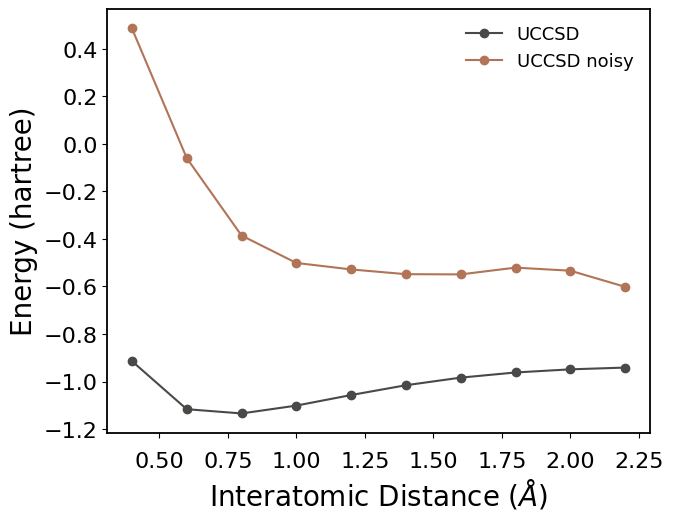

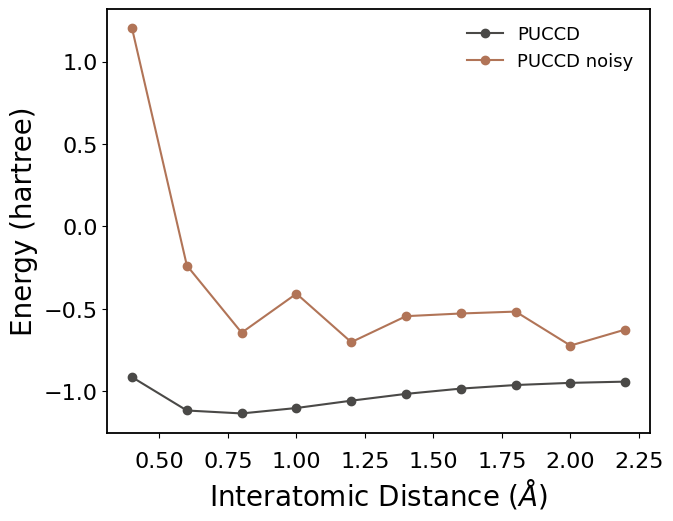

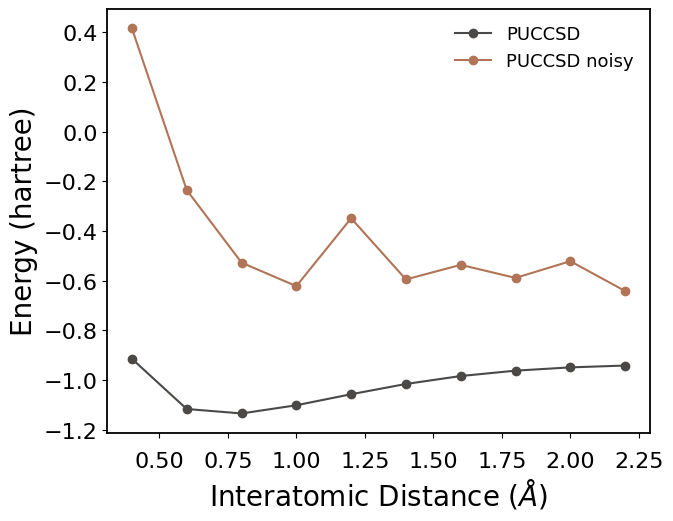

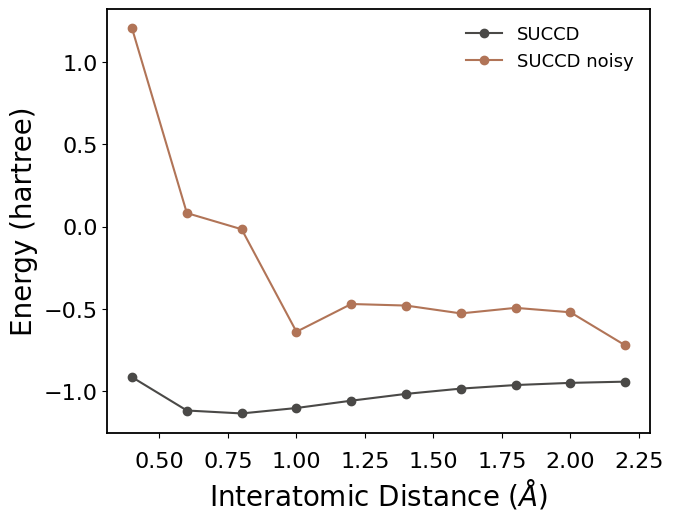

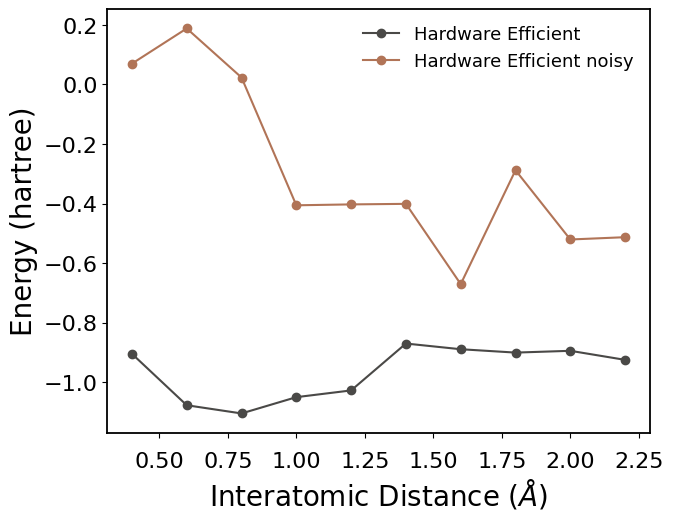

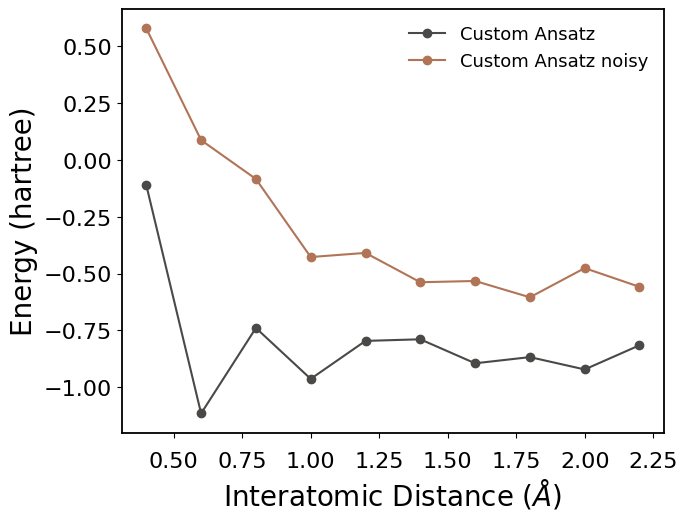

In [248]:
def main():
    
    results = {}
    ansatzes = {
        'UCCSD': UCCSD,
        'PUCCD': PUCCD,
        'PUCCSD': PUCCSD,
        'SUCCD': SUCCD,
        'Hardware Efficient': "HEA",
        'Custom Ansatz': "custom"
    }

    for name, ansatz in ansatzes.items():
        noiseless_energies = VQE_calculation(distances, optimizer, noiseless_estimator, ansatz)
        noisy_energies = VQE_calculation(distances, optimizer, noisy_estimator, ansatz)
        results[name] = {'Energies': noiseless_energies, 'Noisy Energies': noisy_energies}

        my_colors = ['#4A4947', '#B17457', '#AB886D', '#D6C0B3', '#5F6F52', '#A9B388', '#9A4444', '#DE8F5F', '#6C3428', '#FFC26F', '#A9907E', '#A9907E']
        colors = iter(my_colors)
        
        plt.figure(figsize=(7,5.5))
        
        plt.plot(distances, results[name]['Energies'], marker='o', linestyle='-', label=name, color=next(colors))
        plt.plot(distances, results[name]['Noisy Energies'], marker='o', linestyle='-', label=name + ' noisy', color=next(colors))
        
        plt.xlabel("Interatomic Distance ($\AA$)", fontsize=20)
        plt.ylabel("Energy (hartree)", fontsize=20)
        
        legend = plt.legend(fontsize=13)
        legend.set_frame_on(False)  
        
        plt.xticks(fontsize=16)
        plt.yticks(fontsize=16)
        plt.tick_params(axis='x', pad=10)  
        
        ax = plt.gca()
        ax.spines['top'].set_linewidth(1.3)  
        ax.spines['right'].set_linewidth(1.3)  
        ax.spines['bottom'].set_linewidth(1.3)  
        ax.spines['left'].set_linewidth(1.3)    
        ax.yaxis.set_ticks_position('left')
        ax.xaxis.set_ticks_position('bottom')
        # plt.savefig("image_name.jpg", dpi=300, bbox_inches='tight', pad_inches=0.1) #enable to save the images

        plt.show()

if __name__ == "__main__":
    main()